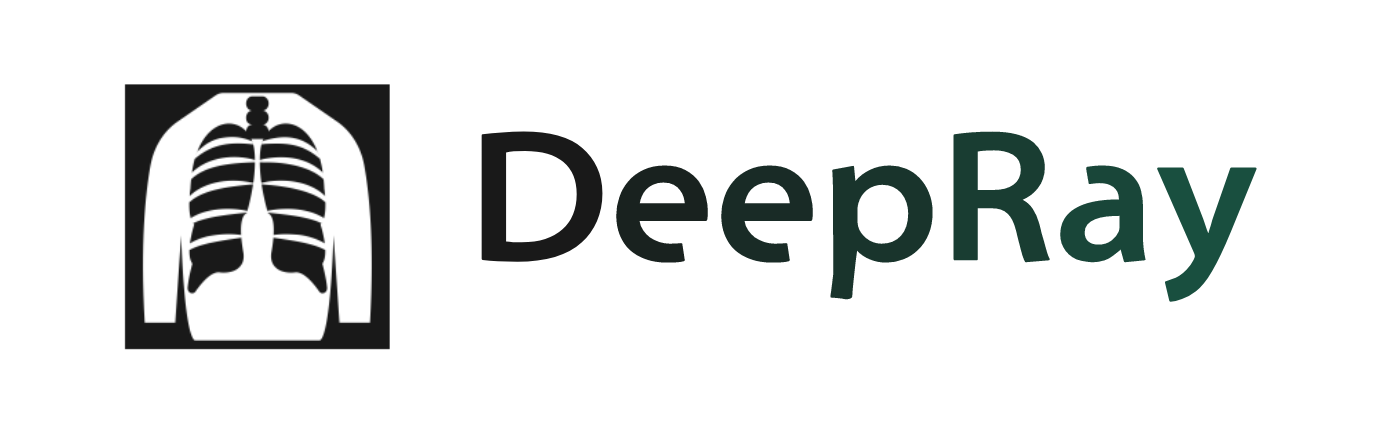

# 1. Introduction
DeepRay is an implementation of medical image Semantic Segmentation using a U-Net architecture. It can detect the infected areas in a COVID-19 patient's chest X-ray image.

# 2. Data
We'll use the <a href="http://qatacov.live/" target="_blank">Qata-COV19</a> dataset. The researchers of Qatar University and Tampere University have compiled the QaTa-COV19 dataset that consists of 9258 COVID-19 chest X-ray images.

In [1]:
!gdown '1w3tZ6sWUY5n3TwY8YMo7L_BKloiVBsLY&confirm=t' # download the dataset
!unzip -q '/content/Qata-COV19.zip' # extract it

Downloading...
From: https://drive.google.com/uc?id=1w3tZ6sWUY5n3TwY8YMo7L_BKloiVBsLY&confirm=t
To: /content/Qata-COV19.zip
100% 5.37G/5.37G [00:45<00:00, 119MB/s] 


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
from PIL import Image
from skimage import transform
import matplotlib.pyplot as plt

This class will create or dataset objects. It will read each chest x-ray image and its corresponding mask, normalize it, apply the given transformations, and return them in a tuple.

In [3]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_names = [image_name for image_name in os.listdir(self.image_dir)]
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        assert type(idx) == int, 'index must be an integer'
        img_path = os.path.join(self.image_dir, self.image_names[idx])
        image = np.asarray(Image.open(img_path), dtype='float32') / 255.
        msk_path = os.path.join(self.mask_dir, f'mask_{self.image_names[idx]}')
        mask = np.asarray(Image.open(msk_path), dtype='float32') / 255.
        sample = image, mask

        if self.transform:
            sample = self.transform(sample)

        return sample

First transformation, to add a dimension to the image and its mask and cast them to torch tensors:

In [4]:
class ToTensor:
    
    def __call__(self, sample):
        image, mask = sample
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)
        return torch.from_numpy(image), torch.from_numpy(mask)

Second transformation, to resize the image and its mask:

In [5]:
class Resize:
    
    def __init__(self, out_size):
        assert type(out_size) == int
        self.out_size = out_size
        
    def __call__(self, sample):
        image, mask = sample
        image_resized = transform.resize(image, (self.out_size, self.out_size))
        mask_resized = transform.resize(mask, (self.out_size, self.out_size)).round()
        return image_resized, mask_resized

Lets create our training and validation datasets:

In [6]:
train_ds = Dataset('/content/QaTa-COV19/QaTa-COV19-v2/Train Set/Images', '/content/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths', transform=torchvision.transforms.Compose([Resize(128), ToTensor()]))
val_ds = Dataset('/content/QaTa-COV19/QaTa-COV19-v2/Test Set/Images', '/content/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths', transform=torchvision.transforms.Compose([Resize(128), ToTensor()]))
print("Training dataset size: ", len(train_ds), "\nValidation dataset size: ", len(val_ds))

Training dataset size:  7145 
Validation dataset size:  2113


Now, see some of our samples:

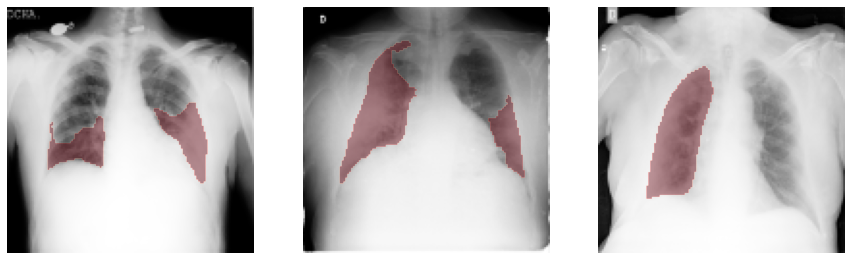

In [7]:
plt.figure(figsize=(15, 45))
for i in range(3):
  plt.subplot(1, 3, i+1).axis('off')
  image, mask = train_ds[i]
  image, mask = image.squeeze(0), mask.squeeze(0)
  plt.imshow(image, cmap='Greys_r')
  plt.imshow(mask, alpha = mask * .4, cmap='Reds')

# Model
The following classes (torch modules) will implement the U-Net architecture. This is the original architecture mentioned in its paper, *Ronneberger, O., et al., U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015*.

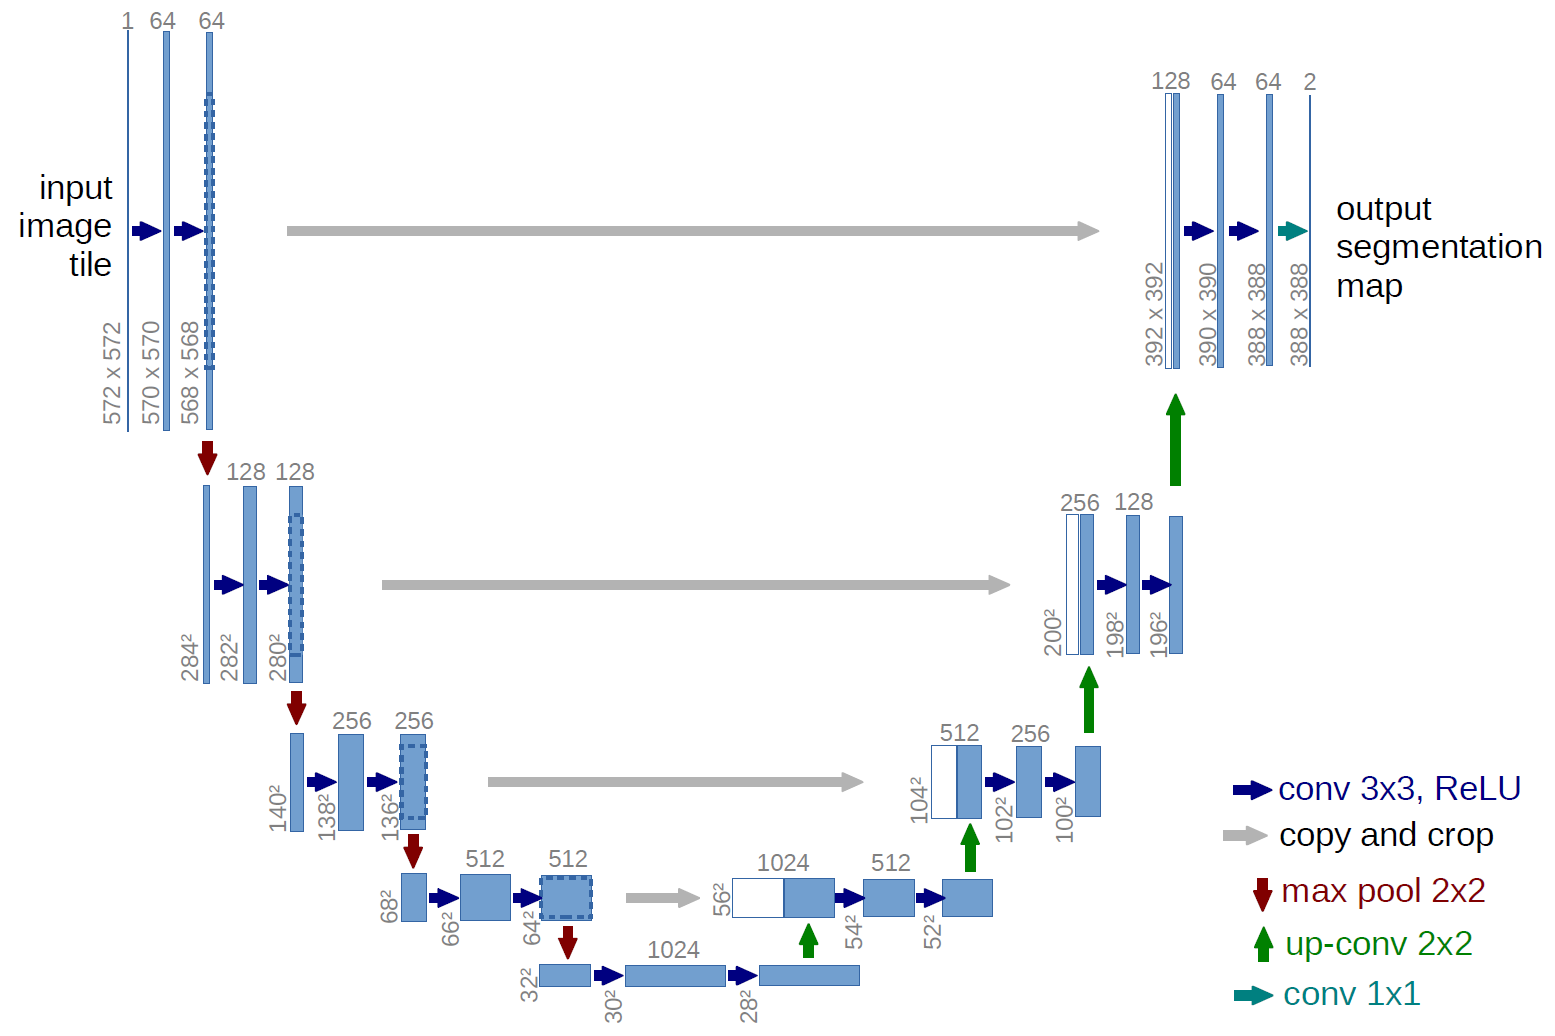

In [8]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.operators = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.operators(x)

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, channels, dropouts, dropout_prob):
        assert len(channels) - 1 == len(dropouts), 'the number of blocks to be created does not match the number of dropouts'
        super(Encoder, self).__init__()
        self.channels = channels
        self.dropouts = dropouts
        self.conv_blocks = nn.ModuleList([ConvBlock(self.channels[i], self.channels[i+1]) for i in range(len(self.channels) - 1)])
        self.dropout = nn.Dropout(p=dropout_prob)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        features = []
        for block, dropout in zip(self.conv_blocks, self.dropouts):
            x = block(x)
            if dropout:
                x = self.dropout(x)
            features.append(x)
            x = self.maxpool(x)
        return features

In [10]:
class UpSampleBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(UpSampleBlock, self).__init__()
        self.operators = nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2), # shape of input is: N, C, H, W
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.operators(x)

In [11]:
class Decoder(nn.Module):
    
    def __init__(self, channels):
        super(Decoder, self).__init__()
        self.channels = channels
        self.n_channels = len(channels)
        self.upsample_blocks = nn.ModuleList([UpSampleBlock(self.channels[i], self.channels[i+1]) for i in range(self.n_channels - 1)])
        self.conv_blocks = nn.ModuleList([ConvBlock(self.channels[i], self.channels[i+1]) for i in range(self.n_channels - 1)])
    
    def forward(self, x, features):

        for upsample_block, conv_block, feature in zip(self.upsample_blocks, self.conv_blocks, features):
            
            x = upsample_block(x)
            x = torch.cat([x, feature], dim=1)
            x = conv_block(x)
        return x

In [12]:
class UNet(nn.Module):
    
    def __init__(self, encoder_channels=(1, 64, 128, 256, 512, 1024), encoder_dropouts=(False, False, False, True, True), dropout_prob=.3,
                 decoder_channels=(1024, 512, 256, 128, 64), n_classes=1):
        super(UNet, self).__init__()
        self.encoder = Encoder(encoder_channels, encoder_dropouts, dropout_prob)
        self.decoder = Decoder(decoder_channels)
        self.head = nn.Conv2d(in_channels=decoder_channels[-1], out_channels=n_classes, kernel_size=1)
    
    def forward(self, x):
        features = self.encoder(x)
        out = self.decoder(features[::-1][0], features[::-1][1:])
        logits = self.head(out)
        preds = torch.sigmoid(logits)
        return preds

# Training
Using torch, we need to specify a device for training. The next cell will do so.

In [14]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device type:', DEVICE.type)

Device type: cuda


Instantiate our model and map it to the device.

In [15]:
training_model = UNet()
training_model.to(DEVICE)

UNet(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (1): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (2): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (3): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), str

The dataset objects are not customized enough for training. Using dataloaders, we'll be able to specify batch size, enable shuffling, data loading threads, etc..

In [16]:
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=32)

Our loss function (criterion) will be binary cross entropy, because our labels contain 0 or 1. We'll use the Adam optimizer.

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(training_model.parameters())

This function implements the training, and returns training loss, training accuracy, validation loss, and validation accuracy.

In [ ]:
def train(model, trainloader, valloader, epochs):
    thresh = len(trainloader) // 10
    train_big_loss = []
    train_big_acc = []
    val_big_loss = []
    val_big_acc = []
    for epoch in range(epochs):
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        for i, data in enumerate(trainloader):
            image, mask = data
            inputs, labels =image.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
                
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            
            train_losses.append(train_loss.cpu().detach())
            train_acc = (outputs.detach().cpu().numpy().round() == labels.cpu().numpy()).mean()
            train_accuracies.append(train_acc)
                
            train_loss.backward()
            optimizer.step()

            if i % thresh == 0:
                print('{:3.0f} / {:3.0f}: loss: {:.4f}, accuracy: {:.4f}'.format(i + 1, len(trainloader), train_loss, train_acc))

        with torch.no_grad():
            for data in valloader:
                image, mask = data
                inputs, labels =image.to(DEVICE), mask.to(DEVICE)
                outputs = model(inputs)

                val_loss = criterion(outputs, labels)
            
                val_losses.append(val_loss.cpu().detach())
                val_acc = (outputs.detach().cpu().numpy().round() == labels.cpu().numpy()).mean()
                val_accuracies.append(val_acc)

        train_l = np.mean(train_losses)
        train_a = np.mean(train_accuracies)
        val_l = np.mean(val_losses)
        val_a = np.mean(val_accuracies)
        print(f'\nEpoch {epoch + 1}:\ntrain_loss: {train_l}, train_accuracy: {train_a}\nval_loss:{val_l}, val_accuracy: {val_a}')
        print("\n=================================")
        train_big_loss.append(train_l)
        train_big_acc.append(train_a)
        val_big_loss.append(val_l)
        val_big_acc.append(val_a)
    print('finished')
    return train_big_loss, train_big_acc, val_big_loss, val_big_acc

Lets train the model for 5 epochs:

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(training_model, trainloader, valloader, 5)

  1 / 224: loss: 0.6756, accuracy: 0.8969
 23 / 224: loss: 0.3797, accuracy: 0.8630
 45 / 224: loss: 0.3179, accuracy: 0.8831
 67 / 224: loss: 0.2656, accuracy: 0.8752
 89 / 224: loss: 0.2914, accuracy: 0.8936
111 / 224: loss: 0.2624, accuracy: 0.8776
133 / 224: loss: 0.2974, accuracy: 0.8484
155 / 224: loss: 0.3072, accuracy: 0.8711
177 / 224: loss: 0.2424, accuracy: 0.8996
199 / 224: loss: 0.2629, accuracy: 0.8738
221 / 224: loss: 0.2531, accuracy: 0.8832

Epoch 1:
train_loss: 0.29016590118408203, train_accuracy: 0.8814570506413777
val_loss:0.23788277804851532, val_accuracy: 0.8849899235056408

  1 / 224: loss: 0.2697, accuracy: 0.8726
 23 / 224: loss: 0.2345, accuracy: 0.8897
 45 / 224: loss: 0.2341, accuracy: 0.8840
 67 / 224: loss: 0.2328, accuracy: 0.8927
 89 / 224: loss: 0.1861, accuracy: 0.9050
111 / 224: loss: 0.1833, accuracy: 0.9137
133 / 224: loss: 0.2032, accuracy: 0.9129
155 / 224: loss: 0.2017, accuracy: 0.9040
177 / 224: loss: 0.2142, accuracy: 0.9125
199 / 224: loss: 0

Lets see how the losses and accuracies changed during training:

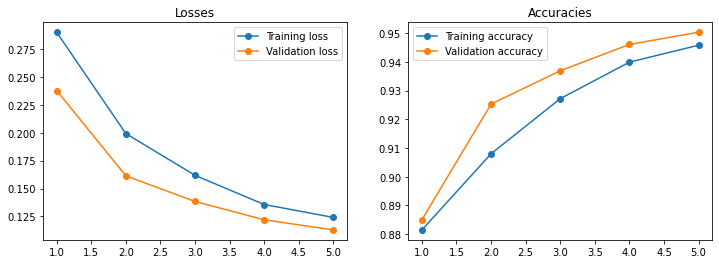

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(np.arange(1, 6), train_loss,'o-', label='Training loss')
plt.plot(np.arange(1, 6), val_loss,'o-', label='Validation loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Accuracies')
plt.plot(np.arange(1, 6), train_acc,'o-', label='Training accuracy')
plt.plot(np.arange(1, 6), val_acc,'o-', label='Validation accuracy')
plt.legend()

# Inference and Results
I trained a model for 133 epochs which you may use in this section. The accuracies changed as follows:

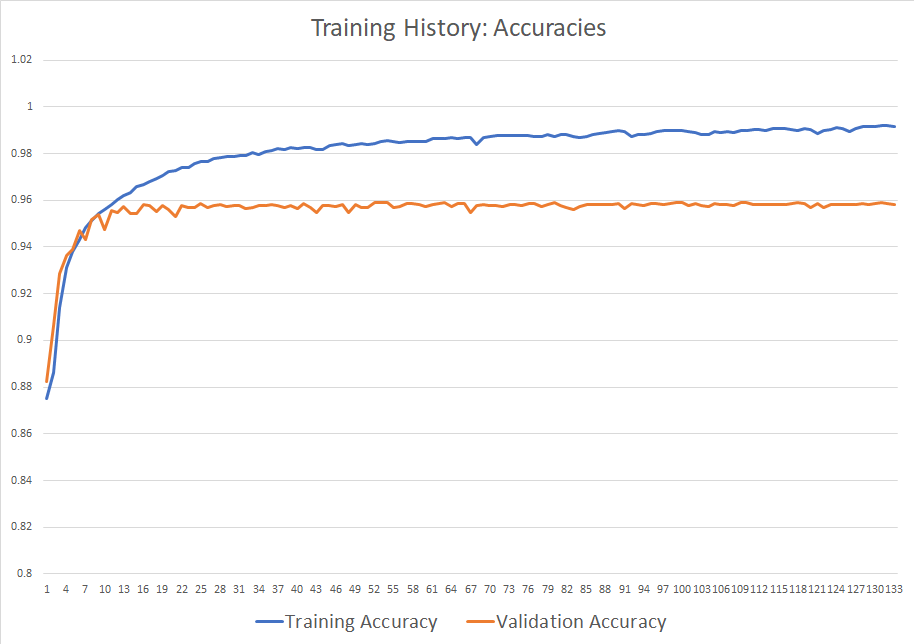

Download the pretrained model's weights (state in torch).

In [19]:
!gdown '1-0bjxEfW_WXyD2CK8ieYSCI6VHxy1Vbg&confirm=t'

Downloading...
From: https://drive.google.com/uc?id=1-0bjxEfW_WXyD2CK8ieYSCI6VHxy1Vbg&confirm=t
To: /content/pre-trained-weights.pt
100% 124M/124M [00:02<00:00, 61.3MB/s]


Instantiate a new model, load the weights, and map it to our device.

In [ ]:
pre_trained_model = UNet()
pre_trained_model.load_state_dict(torch.load('/content/pre-trained-weights.pt', map_location=DEVICE))
pre_trained_model.to(DEVICE)

UNet(
  (encoder): Encoder(
    (conv_blocks): ModuleList(
      (0): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (1): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (2): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (3): ConvBlock(
        (operators): Sequential(
          (0): Conv2d(256, 512, kernel_size=(3, 3), str

Uncomment the second statement if you want to see the results from the model you trained here.

In [ ]:
model = pre_trained_model
#model = training_model

In [ ]:
def plot_prediction(model, dataset, index):
  input = dataset[index][0]
  pred = model(torch.unsqueeze(input, 0).to(DEVICE))
  pred = pred.detach().cpu().numpy()
  pred = pred.round()
  pred = np.squeeze(np.squeeze(pred, axis=0), axis=0)
  mask = torch.squeeze(dataset[index][1])
  input = torch.squeeze(input, 0)
  plt.figure(figsize=(15, 45))
  plt.subplot(1, 2, 1).axis('off')
  plt.title('Prediction')
  plt.imshow(input, cmap='Greys_r')
  plt.imshow(pred, alpha = pred * .4, cmap='Reds')
  plt.subplot(1, 2, 2).axis('off')
  plt.title('Ground Truth')
  plt.imshow(input, cmap='Greys_r')
  plt.imshow(mask, alpha = mask * .4, cmap='Reds')

#### Example one (training instance):

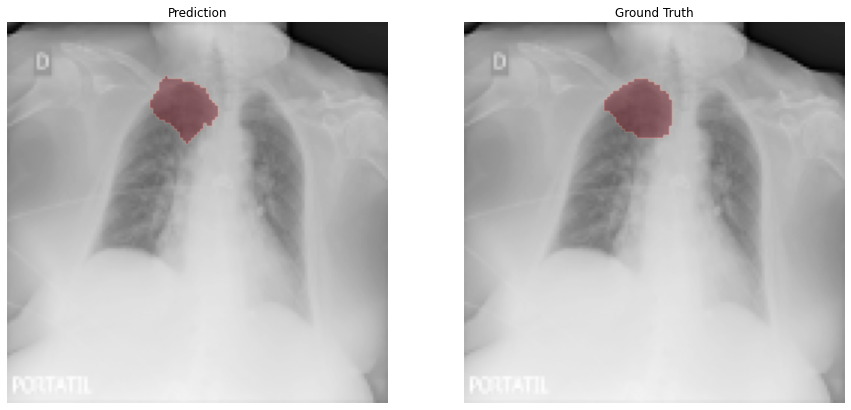

In [ ]:
plot_prediction(model, train_ds, 100)

#### Example two (training instance):

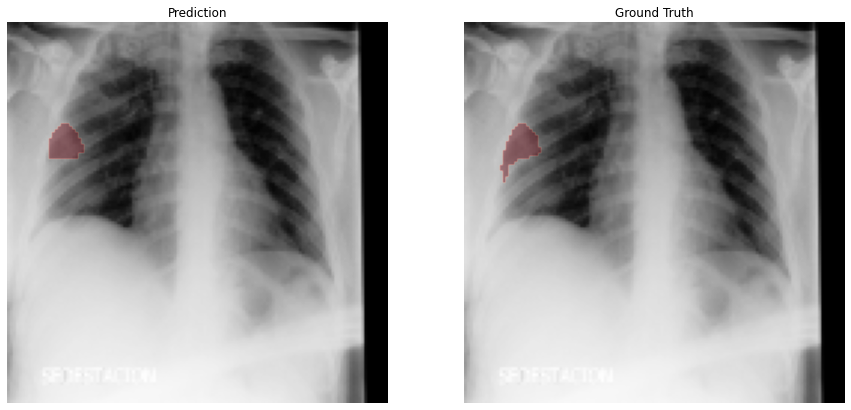

In [ ]:
plot_prediction(model, train_ds, 101)

#### Example three (validation instance):


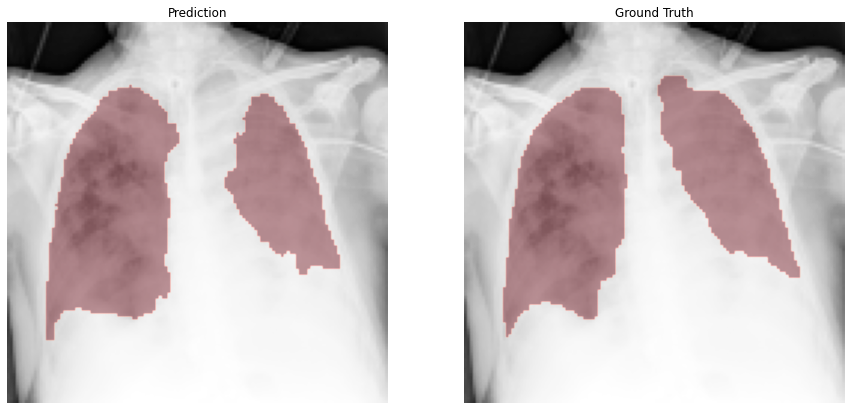

In [ ]:
plot_prediction(model, val_ds, 100)

#### Example four (validation instance):

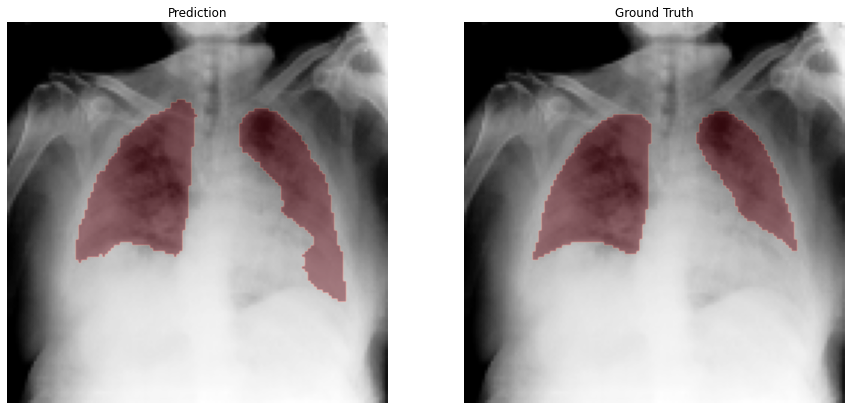

In [ ]:
plot_prediction(model, val_ds, 101)